In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import joblib



In [3]:
#Need to split the Train Set for clusters then combine with new Train of 5 seasons
nba_clustered = pd.read_csv("NBA_Train_Clustered.csv")
labels = nba_clustered[["PLAYER",'Cluster',"Cluster_Label"]]

nba_5Season_train = pd.read_csv("5YearSplitTraining.csv")
nba_clustered = nba_5Season_train.merge(labels, on='PLAYER', how='inner')
nba_clustered


,PLAYER,GP,MIN,PTS,REB,AST,STL,BLK,FG_PCT,FG3_PCT,FT_PCT,TOV,Cluster,Cluster_Label
0,A.C. Green,82.000000,17.200000,4.500000,3.800000,0.50,0.400000,0.100000,0.444000,0.0000,0.712000,0.500000,3,Bench
1,A.J. Guyton,39.000000,16.200000,5.700000,1.050000,1.85,0.250000,0.200000,0.383500,0.3825,0.824000,0.750000,4,Bust
2,AJ Hammons,22.000000,7.400000,2.200000,1.600000,0.20,0.000000,0.600000,0.405000,0.5000,0.450000,0.500000,4,Bust
3,AJ Price,47.000000,14.040000,5.400000,1.360000,2.04,0.460000,0.040000,0.381600,0.3076,0.611400,0.860000,4,Bust
4,Aaron Brooks,65.000000,22.620000,10.760000,1.700000,3.22,0.580000,0.140000,0.415400,0.3528,0.840000,1.660000,2,Role Player
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1550,Zeljko Rebraca,43.000000,14.720000,5.560000,2.960000,0.36,0.240000,0.700000,0.521800,0.0000,0.789000,0.880000,3,Bench
1551,Zendon Hamilton,50.000000,12.950000,4.850000,3.950000,0.30,0.300000,0.250000,0.478500,0.0000,0.675000,0.850000,3,Bench
1552,Zion Williamson,24.000000,27.800000,22.500000,6.300000,2.10,0.700000,0.400000,0.583000,0.4290,0.640000,2.500000,0,Superstar
1553,Zoran Planinic,49.333333,10.666667,3.833333,1.333333,1.10,0.433333,0.066667,0.406667,0.2960,0.675667,0.833333,4,Bust


In [4]:
ncaa_train = pd.read_csv("College2000_2020.csv")

print(f" NBA data: {len(nba_clustered)} players")
print(f" NCAA data: {len(ncaa_train)} players")

# Merge
merged_train = pd.merge(
    ncaa_train,
    nba_clustered[['PLAYER', 'Cluster', 'Cluster_Label']],
    left_on='Name',
    right_on='PLAYER',
    how='inner'
)

print(f" Merged: {len(merged_train)} players")
print(f"\nCluster distribution:")
print(merged_train['Cluster_Label'].value_counts())

 NBA data: 1555 players
 NCAA data: 1233 players
 Merged: 1137 players

Cluster distribution:
Cluster_Label
Bust                360
Role Player         326
Bench               224
Superstar           140
All-Star/Starter     87
Name: count, dtype: int64


In [5]:
# College features (same as Logistic Regression)
college_features = [
    'G', 'MP', 'FG', 'FGA', 'FG%', '3P', '3PA', '3P%',
    'FT', 'FTA', 'FT%', 'TRB', 'AST', 'STL', 'BLK', 'TOV', 'PTS'
]

# Check which features exist
available_features = [f for f in college_features if f in merged_train.columns]
print(f" Available features ({len(available_features)}): {available_features}")

# Create X and y
X = merged_train[available_features].copy()
y = merged_train['Cluster'].copy()

# Handle missing values
X = X.fillna(X.mean())

print(f"\n Feature matrix: {X.shape}")
print(f" Target distribution:")
print(y.value_counts().sort_index())

 Available features (17): ['G', 'MP', 'FG', 'FGA', 'FG%', '3P', '3PA', '3P%', 'FT', 'FTA', 'FT%', 'TRB', 'AST', 'STL', 'BLK', 'TOV', 'PTS']

 Feature matrix: (1137, 17)
 Target distribution:
Cluster
0    140
1     87
2    326
3    224
4    360
Name: count, dtype: int64


In [6]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

print(f" Training: {len(X_train)} samples")
print(f" Testing: {len(X_test)} samples")

# XGBoost doesn't require scaling, but do it for consistency
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(" Features scaled")

 Training: 909 samples
 Testing: 228 samples
 Features scaled


In [7]:
# Initialize XGBoost
xgb_model = XGBClassifier(
    n_estimators=100,           # Number of trees
    max_depth=6,                # Max depth of each tree
    learning_rate=0.1,          # Step size shrinkage
    objective='multi:softmax',  # Multiclass classification
    num_class=5,                # 5 clusters (0-4)
    random_state=42,
    eval_metric='mlogloss',     # Multiclass log loss
    use_label_encoder=False,
    verbosity=0                 # Suppress warnings
)

# Train model
xgb_model.fit(X_train_scaled, y_train)

# Make predictions
y_train_pred = xgb_model.predict(X_train_scaled)
y_test_pred = xgb_model.predict(X_test_scaled)

# Calculate accuracy
train_acc = accuracy_score(y_train, y_train_pred)
test_acc = accuracy_score(y_test, y_test_pred)

print(f"\n Training Accuracy: {train_acc:.4f} ({train_acc*100:.2f}%)")
print(f" Test Accuracy: {test_acc:.4f} ({test_acc*100:.2f}%)")


 Training Accuracy: 1.0000 (100.00%)
 Test Accuracy: 0.4254 (42.54%)


In [8]:
cluster_names = ['Superstar', 'All-Star', 'Role Player', 'Bench', 'Bust']

print(classification_report(y_test, y_test_pred,
                          target_names=cluster_names,
                          digits=3))

              precision    recall  f1-score   support

   Superstar      0.333     0.321     0.327        28
    All-Star      0.000     0.000     0.000        18
 Role Player      0.446     0.508     0.475        65
       Bench      0.466     0.600     0.524        45
        Bust      0.467     0.389     0.424        72

    accuracy                          0.425       228
   macro avg      0.342     0.364     0.350       228
weighted avg      0.407     0.425     0.413       228



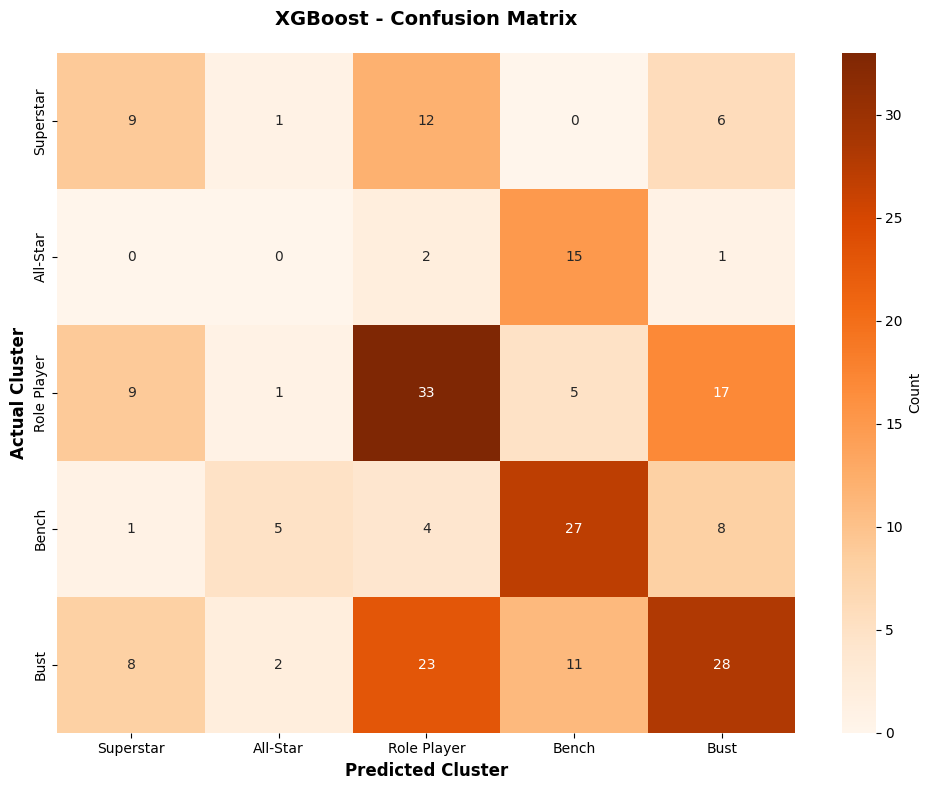


Confusion Matrix:
                    Pred Superstar  Pred All-Star  Pred Role Player  \
Actual Superstar                 9              1                12   
Actual All-Star                  0              0                 2   
Actual Role Player               9              1                33   
Actual Bench                     1              5                 4   
Actual Bust                      8              2                23   

                    Pred Bench  Pred Bust  
Actual Superstar             0          6  
Actual All-Star             15          1  
Actual Role Player           5         17  
Actual Bench                27          8  
Actual Bust                 11         28  


In [9]:
cm = confusion_matrix(y_test, y_test_pred)

# Plot
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Oranges',
            xticklabels=cluster_names,
            yticklabels=cluster_names,
            cbar_kws={'label': 'Count'})
plt.xlabel('Predicted Cluster', fontsize=12, fontweight='bold')
plt.ylabel('Actual Cluster', fontsize=12, fontweight='bold')
plt.title('XGBoost - Confusion Matrix',
          fontsize=14, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

print("\nConfusion Matrix:")
cm_df = pd.DataFrame(cm,
                     index=[f"Actual {n}" for n in cluster_names],
                     columns=[f"Pred {n}" for n in cluster_names])
print(cm_df)


 Top 10 Most Important Features:
Feature  Importance
    3PA    0.169693
    BLK    0.089543
    STL    0.077302
     3P    0.071776
    FG%    0.059640
    AST    0.052425
      G    0.050191
     FT    0.049246
    TRB    0.048964
    FTA    0.045891


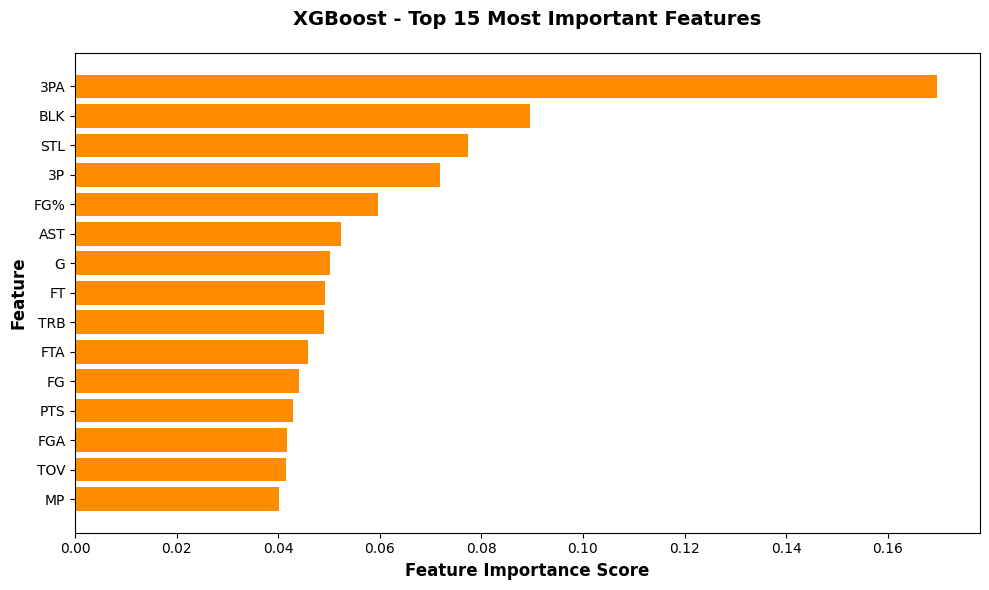

In [10]:
# Get feature importance from XGBoost
feature_importance = pd.DataFrame({
    'Feature': available_features,
    'Importance': xgb_model.feature_importances_
}).sort_values('Importance', ascending=False)

print("\n Top 10 Most Important Features:")
print(feature_importance.head(10).to_string(index=False))

# Plot
plt.figure(figsize=(10, 6))
top_n = 15
top_features = feature_importance.head(top_n)

plt.barh(range(len(top_features)), top_features['Importance'], color='darkorange')
plt.yticks(range(len(top_features)), top_features['Feature'])
plt.xlabel('Feature Importance Score', fontsize=12, fontweight='bold')
plt.ylabel('Feature', fontsize=12, fontweight='bold')
plt.title(f'XGBoost - Top {top_n} Most Important Features',
          fontsize=14, fontweight='bold', pad=20)
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

In [11]:
print(f"Model: XGBoost")
print(f"Number of Trees: 100")
print(f"Max Depth: 6")
print(f"Learning Rate: 0.1")
print(f"Total Players: {len(merged_train)}")
print(f"Training Samples: {len(X_train)}")
print(f"Test Samples: {len(X_test)}")
print(f"Number of Features: {len(available_features)}")
print(f"Training Accuracy: {train_acc:.4f} ({train_acc*100:.2f}%)")
print(f"Test Accuracy: {test_acc:.4f} ({test_acc*100:.2f}%)")

Model: XGBoost
Number of Trees: 100
Max Depth: 6
Learning Rate: 0.1
Total Players: 1137
Training Samples: 909
Test Samples: 228
Number of Features: 17
Training Accuracy: 1.0000 (100.00%)
Test Accuracy: 0.4254 (42.54%)


# Using NBA Clustered 2020-2025 test set and NCAA test set

In [12]:
# Load test data
nba_test_clustered = pd.read_csv("NBA_Test_Clustered.csv")
ncaa_test = pd.read_csv("NCAA_2020_2025.csv")

print(f" NBA test data: {len(nba_test_clustered)} players")
print(f" NCAA test data: {len(ncaa_test)} players")

 NBA test data: 368 players
 NCAA test data: 265 players


In [13]:
# Merge on player name
merged_test = pd.merge(
    ncaa_test,
    nba_test_clustered[['PLAYER', 'Cluster', 'Cluster_Label']],
    left_on='Name',
    right_on='PLAYER',
    how='inner'
)

print(f" Merged test set: {len(merged_test)} players with both college and NBA data")

# Show cluster distribution in test set
print("\nTest set cluster distribution:")
print(merged_test['Cluster_Label'].value_counts())
print("\nNumeric clusters:")
print(merged_test['Cluster'].value_counts().sort_index())

# Show sample
print("\nSample test players:")
print(merged_test[['Name', 'PTS', 'TRB', 'AST', 'Cluster_Label']].head(10))

 Merged test set: 247 players with both college and NBA data

Test set cluster distribution:
Cluster_Label
Bust                121
Role Player          80
Bench                24
Superstar            13
All-Star/Starter      9
Name: count, dtype: int64

Numeric clusters:
Cluster
0     13
1      9
2     80
3     24
4    121
Name: count, dtype: int64

Sample test players:
              Name   PTS   TRB  AST Cluster_Label
0    Aaron Nesmith  14.7   5.3  1.3   Role Player
1    Aaron Wiggins  11.0   4.6  1.6   Role Player
2     Adam Flagler  13.8   2.6  2.6          Bust
3        Adem Bona  10.1   5.6  1.0         Bench
4    Ajay Mitchell  16.1   3.0  4.3   Role Player
5       Alex Ducas   9.0   4.0  1.0          Bust
6    Alize Johnson  14.9  11.1  2.4         Bench
7      Amir Coffey  14.4   3.8  3.2          Bust
8  Andrew Nembhard  10.0   2.9  5.3   Role Player
9    Anthony Black  12.8   5.1  3.9   Role Player


In [14]:
# Use SAME features as training
X_test_2020 = merged_test[available_features].copy()
y_test_2020 = merged_test['Cluster'].copy()

# Handle missing values
X_test_2020 = X_test_2020.fillna(X_test_2020.mean())

print(f" Test feature matrix: {X_test_2020.shape}")
print(f" Test labels: {len(y_test_2020)}")

# Scale using the SAME scaler from training
X_test_2020_scaled = scaler.transform(X_test_2020)

 Test feature matrix: (247, 17)
 Test labels: 247


In [15]:
# Predict using trained XGBoost model
y_pred_2020 = xgb_model.predict(X_test_2020_scaled)

# Get prediction probabilities
y_pred_2020_proba = xgb_model.predict_proba(X_test_2020_scaled)

# Calculate accuracy
test_acc_2020 = accuracy_score(y_test_2020, y_pred_2020)

print(f"\n XGBoost Test Accuracy (2020-2025): {test_acc_2020:.4f} ({test_acc_2020*100:.2f}%)")


 XGBoost Test Accuracy (2020-2025): 0.5182 (51.82%)


In [16]:
cluster_names = ['Superstar', 'All-Star', 'Role Player', 'Bench', 'Bust']

print(classification_report(y_test_2020, y_pred_2020,
                          target_names=cluster_names,
                          digits=3))

              precision    recall  f1-score   support

   Superstar      0.385     0.385     0.385        13
    All-Star      0.417     0.556     0.476         9
 Role Player      0.415     0.425     0.420        80
       Bench      0.500     0.500     0.500        24
        Bust      0.621     0.595     0.608       121

    accuracy                          0.518       247
   macro avg      0.467     0.492     0.478       247
weighted avg      0.522     0.518     0.520       247



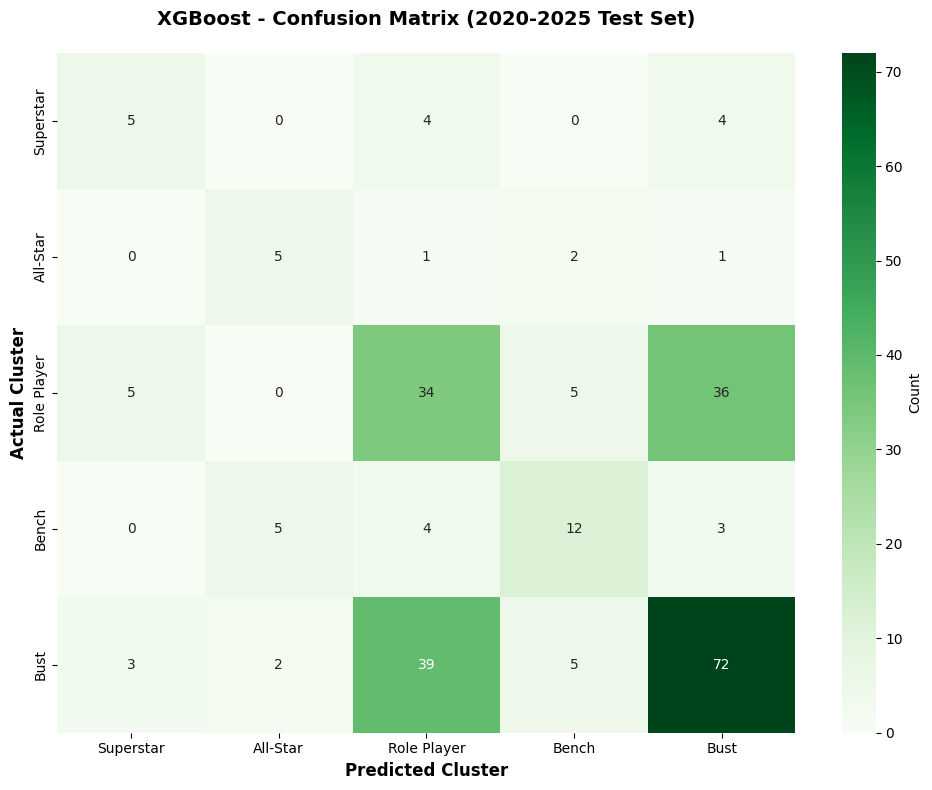


Confusion Matrix:
                    Pred Superstar  Pred All-Star  Pred Role Player  \
Actual Superstar                 5              0                 4   
Actual All-Star                  0              5                 1   
Actual Role Player               5              0                34   
Actual Bench                     0              5                 4   
Actual Bust                      3              2                39   

                    Pred Bench  Pred Bust  
Actual Superstar             0          4  
Actual All-Star              2          1  
Actual Role Player           5         36  
Actual Bench                12          3  
Actual Bust                  5         72  


In [17]:
cm_2020 = confusion_matrix(y_test_2020, y_pred_2020)

# Plot
plt.figure(figsize=(10, 8))
sns.heatmap(cm_2020, annot=True, fmt='d', cmap='Greens',
            xticklabels=cluster_names,
            yticklabels=cluster_names,
            cbar_kws={'label': 'Count'})
plt.xlabel('Predicted Cluster', fontsize=12, fontweight='bold')
plt.ylabel('Actual Cluster', fontsize=12, fontweight='bold')
plt.title('XGBoost - Confusion Matrix (2020-2025 Test Set)',
          fontsize=14, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

print("\nConfusion Matrix:")
cm_df = pd.DataFrame(cm_2020,
                     index=[f"Actual {n}" for n in cluster_names],
                     columns=[f"Pred {n}" for n in cluster_names])
print(cm_df)

In [18]:
merged_test['Predicted_Cluster'] = y_pred_2020
merged_test['Predicted_Label'] = [cluster_names[p] for p in y_pred_2020]
merged_test['Correct'] = merged_test['Cluster'] == merged_test['Predicted_Cluster']

# Add probabilities
for i, label in enumerate(cluster_names):
    merged_test[f'Prob_{label}'] = y_pred_2020_proba[:, i]

# Overall accuracy
correct_pct = merged_test['Correct'].sum() / len(merged_test) * 100
print(f"Overall Accuracy: {correct_pct:.2f}%")

# Correct predictions
print("\n CORRECT PREDICTIONS:")
correct = merged_test[merged_test['Correct'] == True].sort_values('PTS', ascending=False)
print(correct[['Name', 'PTS', 'TRB', 'AST', 'Cluster_Label', 'Predicted_Label']].head(15).to_string(index=False))

# Incorrect predictions
print("\n INCORRECT PREDICTIONS:")
incorrect = merged_test[merged_test['Correct'] == False].sort_values('PTS', ascending=False)
print(incorrect[['Name', 'PTS', 'TRB', 'AST', 'Cluster_Label', 'Predicted_Label']].head(15).to_string(index=False))

Overall Accuracy: 51.82%

 CORRECT PREDICTIONS:
           Name  PTS  TRB  AST    Cluster_Label Predicted_Label
  Markus Howard 21.6  3.2  3.1             Bust            Bust
Cade Cunningham 20.1  6.2  3.5        Superstar       Superstar
  James Wiseman 19.7 10.7  0.3            Bench           Bench
   Johnny Davis 19.3  3.5  NaN             Bust            Bust
   Santi Aldama 19.0  9.2  2.2      Role Player     Role Player
   Cole Anthony 18.5  5.7  4.0      Role Player     Role Player
     Luka Garza 18.2  7.3  1.2             Bust            Bust
      Zach Edey 18.2  9.6  1.3 All-Star/Starter        All-Star
  Nathan Knight 17.1  7.7  2.1             Bust            Bust
  Dalton Knecht 16.9  5.2  1.5             Bust            Bust
    Sam Merrill 16.8  3.6  3.6             Bust            Bust
    Ayo Dosunmu 16.7  4.8  3.9      Role Player     Role Player
   Keifer Sykes 16.5  3.7  4.1             Bust            Bust
   Ryan Rollins 16.4  5.6  3.1      Role Player     Role